# Curable Sexually-Transmitted Diseases Model

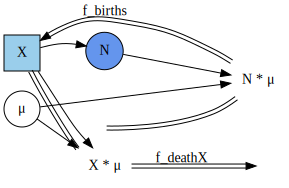

In [1]:
using GraphViz

using StockFlow
using StockFlow.Syntax

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams

openX = Open(
    (@stock_and_flow begin

        :stocks
        X

        :parameters
        μ

        :dynamic_variables
        v_births = N * μ
        v_deathX = X * μ

        :flows
        CLOUD => f_births(v_births) => X
        X => f_deathX(v_deathX) => CLOUD

        :sums
        N = [X]

        end
    ),
    # feet
    foot(:X,:N,:X=>:N)

)

GraphF(apex(openX))

going to compose all μ in Rewriting.  Shouldn't be necessary on params.

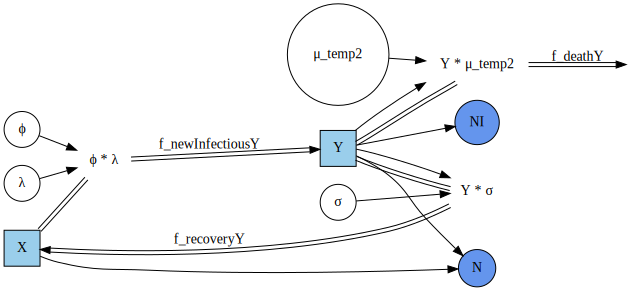

In [2]:
openSIS_A = Open(
    (@stock_and_flow begin

        :stocks
        X
        A

        :parameters
        μ_temp1
        ϕ_complement
        σ′
        cβ

        :dynamic_variables
        v_inf₁ = cβ * NI
        v_inf₂ = v_inf₁ / N
        v_inf₃ = v_inf₂ * X
        v_inf₄ = v_inf₃ * ϕ_complement

        v_deathA = A * μ_temp1

        :flows
        X => f_newInfectiousA(v_inf₄) => A
        A => f_deathA(v_deathA) => CLOUD
        A => f_recoveryA(A * σ′) => X

        :sums
        N = [X, A]
        NI = [A]

    end
    ),
     # feet
     foot(:X,:N,:X=>:N),
     foot((),:NI,())

)

GraphF(apex(openSIS_A))

openSIS_Y = Open(
    (@stock_and_flow begin

    :stocks
    X
    Y

    :parameters
    μ_temp2
    ϕ
    σ
    λ

    :dynamic_variables
    v_inf₄ = ϕ * λ
    # at present, lambda needs to come second
    # in algebraic rewriting, position of variables matters for homomorphisms.
    # When we later have *(ϕ), phi comes first, because it's the only variable

    v_deathY = Y * μ_temp2

    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(v_deathY) => CLOUD
    Y => f_recoveryY(Y * σ) => X

    :sums
    N = [X, Y]
    NI = [Y]

end
        ),

     # feet
     foot(:X,:N,:X=>:N),
     foot((),:NI,())

)

GraphF(apex(openSIS_Y))

define the UWD-algebra

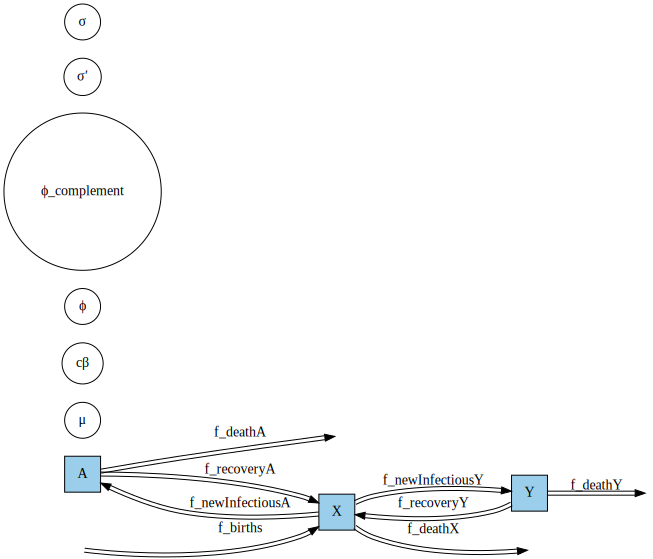

In [3]:
uwd = @relation (XN,NI) begin
    X(XN)
    XA(XN,NI)
    XY(XN,NI)
end;
display_uwd(uwd)

XAY_model = oapply(uwd,Dict(
    :X=>openX,
    :XA=>openSIS_A,
    :XY=>openSIS_Y
    )) |> apex
GraphF(XAY_model)

XAY_model

L = @stock_and_flow begin
    :stocks
    X
    Y
    A

    :parameters
    μ
    μ_temp1
    μ_temp2
    λ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = ϕ * λ

    v_deathA = A * μ_temp1
    v_deathY = Y * μ_temp2

    v_births = N * μ
    v_deathX = X * μ

    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(v_deathY) => CLOUD
    A => f_deathA(v_deathA) => CLOUD

    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD



    :sums
    N = [X,Y,A]
    NI = [Y,A]
    end;



GraphF(L)

I = @stock_and_flow begin
    :stocks
    A
    X
    Y

    :parameters
    μ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = *(ϕ)


    v_deathA = *(A)
    v_deathY = *(Y)

    v_births = N * μ
    v_deathX = X * μ






    :flows
    X => f_newInfectiousY(v_inf₄) => Y
    Y => f_deathY(v_deathY) => CLOUD
    A => f_deathA(v_deathA) => CLOUD

    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD



    :sums
    N = [X,Y,A]
    NI = [Y,A]
    end;




GraphF(I)

R = @stock_and_flow begin
    :stocks
    A
    X
    Y

    :parameters
    μ
    cβ
    ϕ

    :dynamic_variables
    v_inf₁ = cβ * NI
    v_inf₂ = v_inf₁ / N
    v_inf₃ = v_inf₂ * X
    v_inf₄ = ϕ * v_inf₃

    v_deathA = A * μ
    v_deathY = Y * μ

    v_births = N * μ
    v_deathX = X * μ

    :flows
    X => f_newInfectiousY(v_inf₄) => Y

    Y => f_deathY(v_deathY) => CLOUD
    A => f_deathA(v_deathA) => CLOUD

    CLOUD => f_births(v_births) => X
    X => f_deathX(v_deathX) => CLOUD


    :sums
    N = [X,Y,A]
    NI = [Y,A]
    end;



GraphF(R)

using AlgebraicRewriting
using AlgebraicRewriting: rewrite
const hom = Catlab.CategoricalAlgebra.homomorphism
rule = Rule(hom(I,L), hom(I,R))

XAY_model_rewritten = rewrite(rule, XAY_model)

GraphF(XAY_model_rewritten)

GraphF(XAY_model_rewritten,type="SF")

define values of constant parameters
unit: year

In [4]:
p = LVector(
    cβ=15*0.7, μ=1/15,ϕ=(0.95+0.4)/2,σ=12/4,σ′=12/4,ϕ_complement=(1.0 - ((0.95+0.4)/2))
)

6-element LabelledArrays.LArray{Float64, 1, Vector{Float64}, (:cβ, :μ, :ϕ, :σ, :σ′, :ϕ_complement)}:
           :cβ => 10.5
            :μ => 0.06666666666666667
            :ϕ => 0.675
            :σ => 3.0
           :σ′ => 3.0
 :ϕ_complement => 0.32499999999999996

define initial values for stocks

In [5]:
u0 = LVector(
    X=990, A=5, Y=5
)

3-element LabelledArrays.LArray{Int64, 1, Vector{Int64}, (:X, :A, :Y)}:
 :X => 990
 :A => 5
 :Y => 5

results are tested the same as the Anylogic model

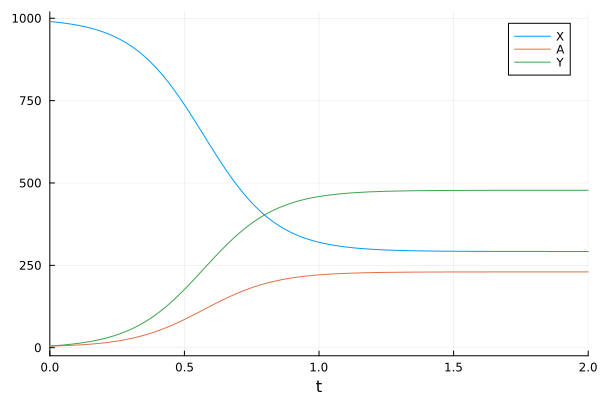

In [6]:
prob_XAY = ODEProblem(vectorfield(XAY_model_rewritten),u0,(0.0,2.0),p);
sol = solve(prob_XAY,Tsit5(),abstol=1e-8);
plot(sol)

to have the figures plotted fix to the wider of the cells

In [7]:
HTML("""
<style>
.output_svg div{
  width: 100% !important;
  height: 100% !important;
}
</style>
""")

HTML{String}("<style>\n.output_svg div{\n  width: 100% !important;\n  height: 100% !important;\n}\n</style>\n")